In [22]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [23]:
# Main libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
from glob import glob
from sklearn.model_selection import train_test_split

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Neural Network
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
# Constants
BATCH_SIZE = 32
HEIGHT, WIDTH = 50, 200

# Loading Dataset 

In [25]:
# Data Configs
data_path = 'D:\\AI\\archive (1)\\samples'

# Get all the file names
captcha_files = glob(data_path + "/*")
captcha_files.remove('D:\\AI\\archive (1)\\samples\\samples')

print(f"Total Samples: {len(captcha_files)}")
print(f"Samples: {captcha_files[:5]}")

Total Samples: 1070
Samples: ['D:\\AI\\archive (1)\\samples\\226md.png', 'D:\\AI\\archive (1)\\samples\\22d5n.png', 'D:\\AI\\archive (1)\\samples\\2356g.png', 'D:\\AI\\archive (1)\\samples\\23mdg.png', 'D:\\AI\\archive (1)\\samples\\23n88.png']


# Preprocessing

In [26]:
# Features & Labels
image_paths = captcha_files
labels = [path.split('/')[-1].split('.')[0] for path in image_paths]

print(f"Labels: {labels[:5]}")

Labels: ['D:\\AI\\archive (1)\\samples\\226md', 'D:\\AI\\archive (1)\\samples\\22d5n', 'D:\\AI\\archive (1)\\samples\\2356g', 'D:\\AI\\archive (1)\\samples\\23mdg', 'D:\\AI\\archive (1)\\samples\\23n88']


In [27]:
# Extract the set of Unique Characters
unique_chars = sorted(set(char for label in labels for char in label))
print(f"Unique Chars: {unique_chars}")
print(f"Total Number of Unique Chars: {len(unique_chars)}")

Unique Chars: [' ', '(', ')', '1', '2', '3', '4', '5', '6', '7', '8', ':', 'A', 'D', 'I', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'p', 'r', 's', 'v', 'w', 'x', 'y']
Total Number of Unique Chars: 35


In [28]:
# The max length os the Captchas
max_len = max((len(label) for label in labels))
print(f"Max length of Captcha: {max_len}")

Max length of Captcha: 31


In [29]:
# Mapping Chars to Nums
char_to_num = layers.StringLookup(vocabulary=unique_chars, mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [30]:
print(f"Vocab: {char_to_num.get_vocabulary()}")

Vocab: ['[UNK]', ' ', '(', ')', '1', '2', '3', '4', '5', '6', '7', '8', ':', 'A', 'D', 'I', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'p', 'r', 's', 'v', 'w', 'x', 'y']


In [31]:
# Splitting data into Training and Testing Counter parts
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, shuffle=True, random_state=42)

# Training & Testing Dataset
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print(f"Training Size : {len(X_train)} samples.")
print(f"Testing Size  : {len(X_test)} samples.")

Training Size : 963 samples.
Testing Size  : 107 samples.


In [32]:
def preprocess(image_path, label):

    # Load image from image path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (HEIGHT, WIDTH))
    image = image/255.
    image = tf.cast(image, tf.float32)

    # Convert label to numerical label
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"ImageInput":image, "LabelInput":label}

In [33]:
# Apply the preprocessing function
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = raw_test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

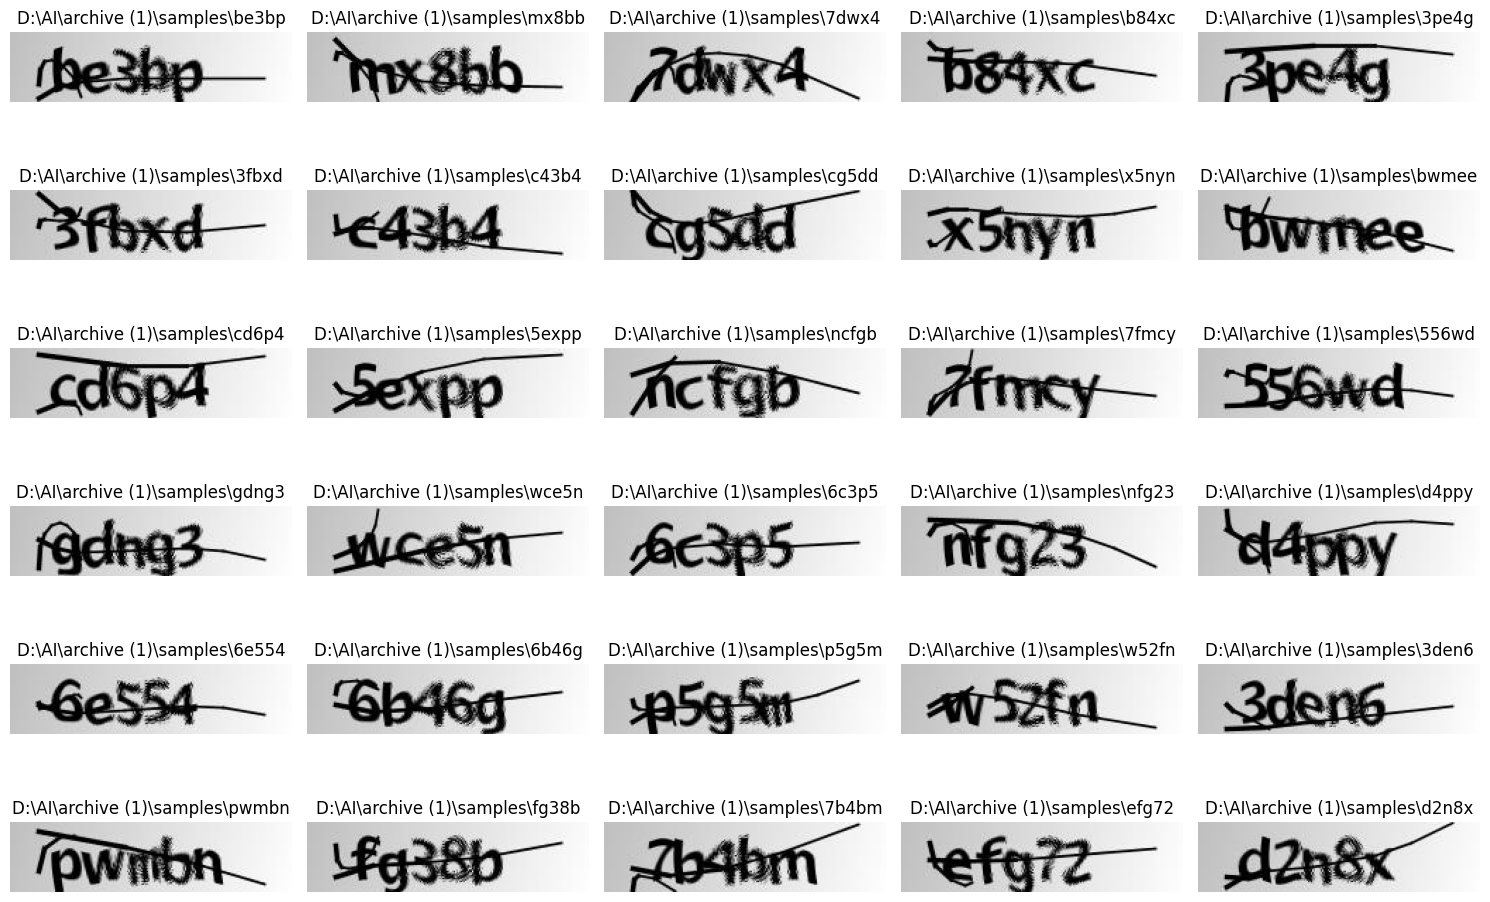

In [34]:
# Loop over images
plt.figure(figsize=(15, 10))

# Select a set of images
data = next(iter(train_ds.batch(32)))
images, labels = data['ImageInput'], data['LabelInput']

# Loop over the subset
for index in range(1, 31):

    # Extract info
    image = images[index]
    text_label = tf.strings.reduce_join(num_to_char(labels[index])).numpy().decode("utf-8")

    # Plot the subplot
    plt.subplot(6, 5, index)
    plt.imshow(image)
    plt.title(text_label)
    plt.axis('off')

# Plot Configs
plt.tight_layout()
plt.show()

In [35]:
# Final process
train_ds = train_ds.repeat(5).shuffle(1000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

# CTC Loss

In [36]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ctc_batch_loss = keras.backend.ctc_batch_cost

    def call(self, true, pred):

        batch_size = tf.cast(
            tf.shape(true)[0],
            dtype='int64'
        )

        input_length = tf.cast(
            tf.shape(pred)[1],
            dtype='int64'
        )

        output_length = tf.cast(
            tf.shape(true)[1],
            dtype='int64'
        )

        input_length *= tf.ones(shape=(batch_size, 1), dtype='int64')
        output_length *= tf.ones(shape=(batch_size, 1), dtype='int64')

        loss = self.ctc_batch_loss(true, pred, input_length, output_length)
        self.add_loss(loss)

        return pred

# CNN

In [37]:
# CNN Encoder
encoder = keras.Sequential([
    layers.Input(shape=(HEIGHT, WIDTH, 3), dtype='float32'),
    layers.Conv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal',
        name="ConvLayer1"
    ),
    layers.MaxPool2D(name="MaxPoolLayer1"),
    layers.Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal',
        name="ConvLayer2"
    ),
    layers.MaxPool2D(name="MaxPoolLayer2"),
    layers.Reshape(target_shape=(WIDTH//4, (HEIGHT//4)*64), name="ReshapeEmbedding"),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', name="ImageEmbeding")

], name="CNN-Encoder")

# LSTM

In [38]:
# LSTM Decoder
decoder = keras.Sequential([
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25), name="LSTMLayer1"),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25), name="LSTMLayer2"),
], name="LSTM-Decoder")

# Model Prep

In [39]:
# Input layers for the Image and Label input
image_input = layers.Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name="ImageInput")
label_input = layers.Input(shape=(None, ), dtype='float32', name="LabelInput")

# Encoder & decoder network
embeddings = encoder(image_input)
dropout = layers.Dropout(0.5, name="EmbeddingDropout")(embeddings)
output_seq = decoder(dropout)
output_seq = layers.Dense(units=len(char_to_num.get_vocabulary())+1, activation='softmax', name="OutputSequence")(output_seq)

# CTC Loss Layer
ctc_loss = CTCLayer(name="CTCLoss")(label_input, output_seq)

# CTC Model
ctc_model = keras.Model(
    inputs=[image_input, label_input],
    outputs=[ctc_loss],
    name="CTCModel"
)

# Model Architecture Summary
ctc_model.summary()

Model: "CTCModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ImageInput          │ (None, 50, 200,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN-Encoder         │ (None, 50, 64)    │     68,608 │ ImageInput[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingDropout    │ (None, 50, 64)    │          0 │ CNN-Encoder[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM-Decoder        │ (None, 50, 64)    │     49,664 │ EmbeddingDropout… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LabelInput          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OutputSequence      │ (None, 50, 37)    │      2,405 │ LSTM-Decoder[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CTCLoss (CTCLayer)  │ (None, 50, 37)    │          0 │ LabelInput[0][0], │
│                     │                   │            │ OutputSequence[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,677 (471.39 KB)

 Trainable params: 120,677 (471.39 KB)

 Non-trainable params: 0 (0.00 B)

# Visualization

In [40]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [51]:
import pandas as pd
from pandas_profiling import ProfileReport

history_df = pd.DataFrame(history.history)


In [52]:
profile = ProfileReport(history_df, minimal=True)


In [53]:
profile.to_file('report.html')


Export report to file: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


The Visualization report in html will be submitted

In [48]:
# Convert to a DataFrame
history_df = pd.DataFrame(history.history)

# Visualize the History
fig = px.line(history_df, y=["loss", "val_loss"], title="Learning Curve")
fig.update_layout(
    xaxis_title="Epochs",
    yaxis_title="Sparse Categorical Crossentropy",
)
fig.show()

# Model Training

In [43]:
# Model Compilation
ctc_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Model Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3
)

# Model training
history = ctc_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[
        early_stopping,
        lr_scheduler
    ]
)

Epoch 1/10


151/151 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - loss: 104.8894 - val_loss: 59.6413 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - loss: 49.1036 - val_loss: 25.0765 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - loss: 23.2136 - val_loss: 18.1270 - learning_rate: 0.0010
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - loss: 17.8211 - val_loss: 16.7613 - learning_rate: 0.0010
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - loss: 16.5421 - val_loss: 16.1202 - learning_rate: 0.0010
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - loss: 15.8779 - val_loss: 15.6594 - learning_rate: 0.0010
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - loss: 15.3913 - val_loss: 15.2859 - learning_rate: 0.0010
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - loss: 14.9915 - val_loss: 14.9529 - learning_rate: 0.0010
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - loss: 14.6399 - val_loss: 14.6999

# Model Inference

In [44]:
testing_loss = ctc_model.evaluate(test_ds,  verbose=0)
print(f"Model Testing Loss: {testing_loss}")

Model Testing Loss: 14.541769981384277


In [45]:
# Define input and output tensors
image_input_tensor = ctc_model.inputs[0]
output_sequence_tensor = ctc_model.get_layer("OutputSequence").output

# Create the prediction model using input and output tensors
ocr_pred_model = keras.Model(inputs=image_input_tensor, outputs=output_sequence_tensor)
ocr_pred_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ImageInput (InputLayer)         │ (None, 50, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN-Encoder (Sequential)        │ (None, 50, 64)         │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EmbeddingDropout (Dropout)      │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM-Decoder (Sequential)       │ (None, 50, 64)         │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputSequence (Dense)          │ (None, 50, 37)         │         2,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,677 (471.39 KB)

 Trainable params: 120,677 (471.39 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
def decode_prediction(model_pred_seq):

    # Compute the Input length
    input_length = np.ones(model_pred_seq.shape[0]) * model_pred_seq.shape[1]

    # Decode the model predictions (& select the required stuff)
    decode = tf.squeeze(keras.backend.ctc_decode(model_pred_seq, input_length=input_length, greedy=True)[0])

    # Conver the numbers to their respective characters
    decoded_text = [tf.strings.reduce_join(num_to_char(nums)) for nums in decode]

    # Convert thode characters back to a normal string
    decoded_text = [text.numpy().decode().replace('[UNK]', '') for text in decoded_text]

    return decoded_text

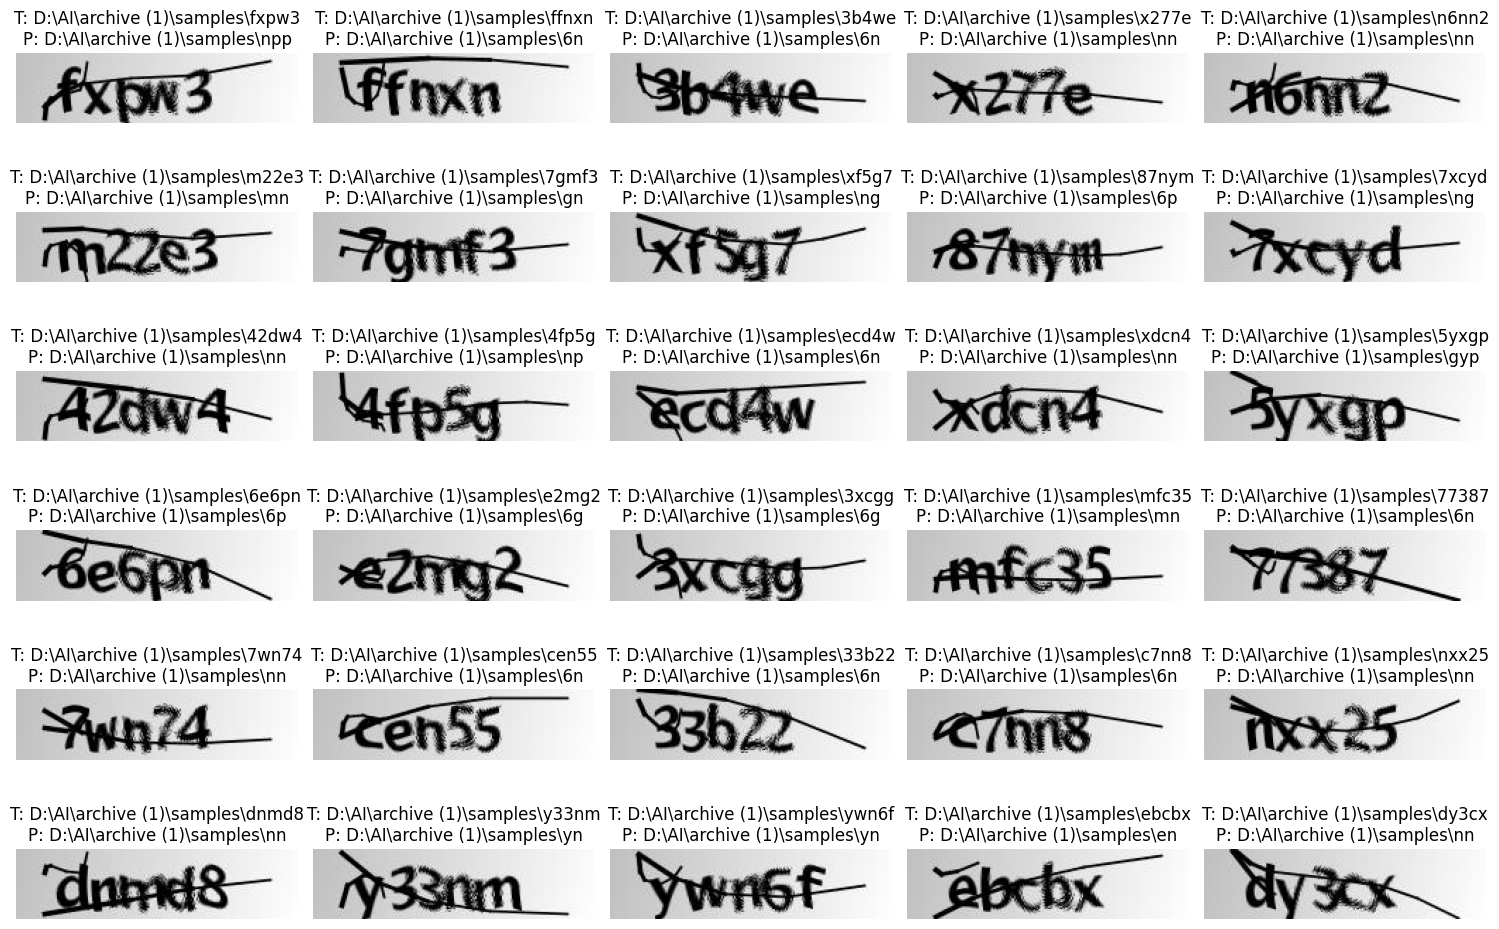

In [47]:
# Initialize Figure Size
plt.figure(figsize=(15, 10))

# Loop over a subset of images in the dataset
for data in test_ds.take(1):

    # Loop over individual images and labels
    images = data['ImageInput']
    labels = data['LabelInput']
    model_preds = decode_prediction(ocr_pred_model.predict(images, verbose=0))

    for index in range(min(30, len(images))):

        # Extract info for each image and label
        image = images[index]
        true_label = labels[index]
        pred_label = model_preds[index]

        # Decode labels from numerical to text
        true_text = tf.strings.reduce_join(num_to_char(true_label)).numpy().decode("utf-8")

        # Plot the subplot
        plt.subplot(6, 5, index + 1)
        plt.imshow(image)  # Assuming images are grayscale
        plt.title(f'T: {true_text}\nP: {pred_label}')
        plt.axis('off')

# Plot Configs
plt.tight_layout()
plt.show()

In [ ]:
pip install pytesseract


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pytesseract
from PIL import Image

# Path to the captcha image
captcha_image_path = "D:\\AI\\archive (1)\\samples\\2g783.png"

# Open the image using PIL (Python Imaging Library)
captcha_image = Image.open(captcha_image_path)

# Use Tesseract to extract text from the image
captcha_text = pytesseract.image_to_string(captcha_image)

# Print the extracted text
print("Extracted Text:", captcha_text)


TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.